## Import necessary packages

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from utils import *
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt

## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [2]:
path = '/home/harsh/Downloads/ATAT/'

## Initialize parameters
bs = 32
lr = 1e-3
threshold = 0.3
margin = 1.5
epochs = 40


## Initialize network variables

In [3]:
## Initialize network
model = SiameseNetwork()
model = model.cuda()

model.apply(initialize_weights)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim,8)

## Initialize loss
criterion = ContrastiveLoss(margin)
# criterion = torch.nn.BCEWithLogitsLoss()

## Create Datasets and Dataloaders

In [4]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                                              std=(0.229, 0.224, 0.225))
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                                              std=(0.229, 0.224, 0.225))
        ])

train_ds = ATATContrast(ImageFolder(root = path + 'train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + 'valid',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + 'test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

## Show model architecture

In [5]:
summary(model,[(3,112,92),(3,112,92)],batch_size = bs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 32, 110, 90]             896
       BatchNorm2d-2          [32, 32, 110, 90]              64
              ReLU-3          [32, 32, 110, 90]               0
         MaxPool2d-4           [32, 32, 55, 45]               0
            Conv2d-5           [32, 64, 53, 43]          18,496
       BatchNorm2d-6           [32, 64, 53, 43]             128
              ReLU-7           [32, 64, 53, 43]               0
         MaxPool2d-8           [32, 64, 26, 21]               0
            Conv2d-9           [32, 64, 24, 19]          36,928
      BatchNorm2d-10           [32, 64, 24, 19]             128
             ReLU-11           [32, 64, 24, 19]               0
        MaxPool2d-12            [32, 64, 12, 9]               0
           Linear-13                 [32, 4096]      28,315,648
          Sigmoid-14                 [3

## Train the model

In [6]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(train_dl):
        optim.zero_grad()
        output1,output2 = model(input1.cuda(),input2.cuda())
        out = model(input1.cuda(),input2.cuda())
        
        loss = criterion(output1,output2,target.cuda())
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)
    
    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    

    valid_epoch_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(output1,output2,target.cuda(),threshold)
        val_pos_accuracy+=pos_acc
        val_neg_accuracy+=neg_acc
        num_pos+=pos_sum
        num_neg+=neg_sum

    valid_epoch_loss /= len(valid_ds)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg

    valid_loss.append(valid_epoch_loss)



    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_epoch_loss,val_pos_accuracy,val_neg_accuracy))



Epoch [1/40] ----> Training loss :0.34295420795679094 

Validation loss :0.03757550120353699 			 P Acc : 0.8, N Acc: 0.76

Epoch [2/40] ----> Training loss :0.268356778472662 

Validation loss :0.029607973992824554 			 P Acc : 0.7368421052631579, N Acc: 0.7619047619047619

Epoch [3/40] ----> Training loss :0.30860307812690735 

Validation loss :0.030146139860153198 			 P Acc : 0.7727272727272727, N Acc: 0.6666666666666666

Epoch [4/40] ----> Training loss :0.34889830052852633 

Validation loss :0.02236802726984024 			 P Acc : 0.6666666666666666, N Acc: 0.92

Epoch [5/40] ----> Training loss :0.3207875743508339 

Validation loss :0.019010468572378158 			 P Acc : 0.47619047619047616, N Acc: 1.0

Epoch [6/40] ----> Training loss :0.08969350159168243 

Validation loss :0.01874089762568474 			 P Acc : 0.55, N Acc: 1.0

Epoch [7/40] ----> Training loss :0.08223831914365291 

Validation loss :0.029978187382221223 			 P Acc : 0.47058823529411764, N Acc: 0.8260869565217391

Epoch [8/40] ----> T

## Plot losses

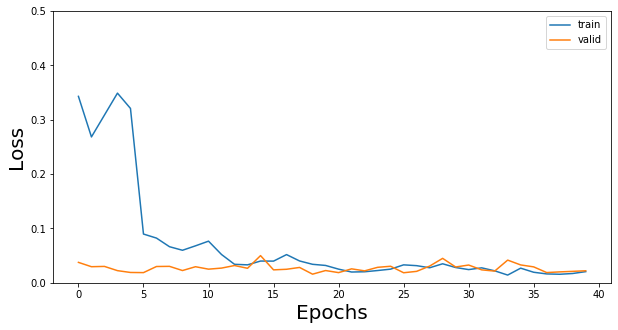

In [64]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,0.5)
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [59]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(d[0]),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

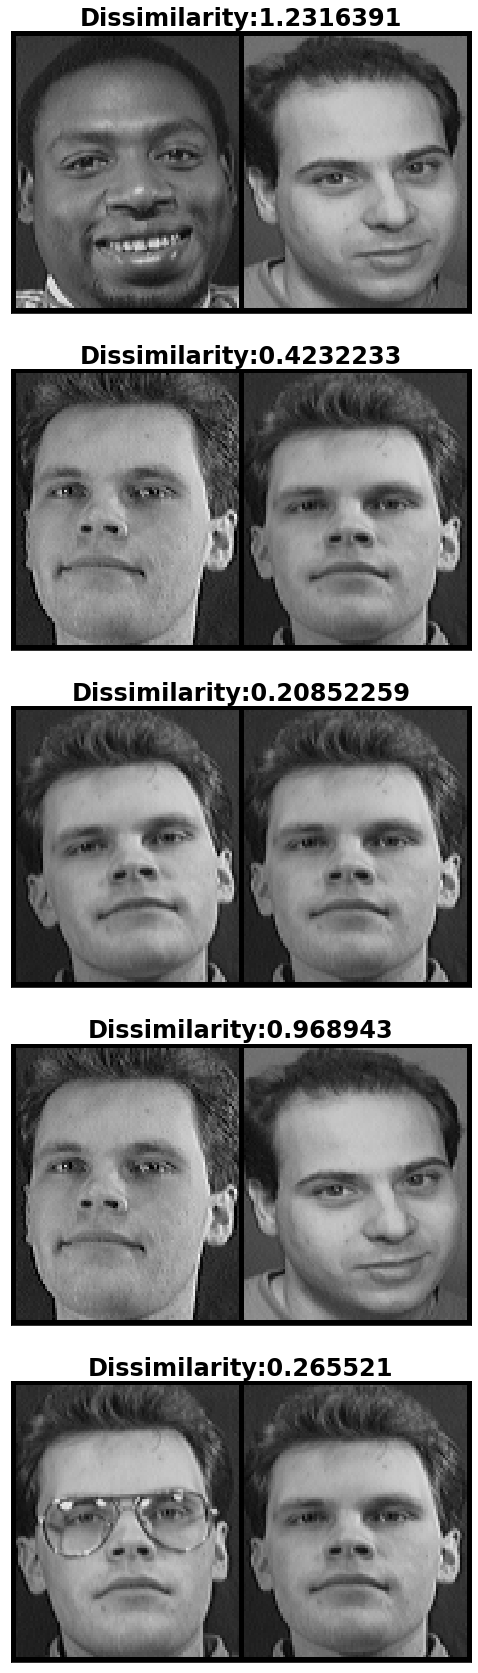

In [60]:
fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(test_ds))
    input1,input2,target = test_ds[idx]
    output1,output2 = model(input1.unsqueeze(0).cuda(),input2.unsqueeze(0).cuda())
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)
    
    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

## Save the trained model for future usage

In [62]:
torch.save(model.state_dict(),'./atat_contrast.pth')

In [63]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./atat_contrast.pth'))
new_model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=6912, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, 